# Purpose:
- QC the signals
# Background:
- While manual curation, I observed some sessions where signals change abruptly, either at the beginning or at the end.
- Could be due to wrong plane allocation
# Methods:
- Save rasterplot of fluorescence, and go over manually.
- Just the selected sessions for now.
    - Worry about spontaneous sessions and piezo sessions later if needed.


In [22]:
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

base_dir_1 = Path('F:/')
base_dir_2 = Path('D:/')
mice = [25,27,30,36,39]
planes = range(1,9)

# First, save dff

In [122]:
from scipy.ndimage import filters
def calculate_suite2p_dff(F: np.ndarray, baseline: str, win_baseline: float,
               sig_baseline: float, fs: float, prctile_baseline: float = 8):
    win = int(win_baseline*fs)
    if baseline == 'maximin':
        Flow = filters.gaussian_filter(F,    [0., sig_baseline])
        Flow = filters.minimum_filter1d(Flow,    win)
        Flow = filters.maximum_filter1d(Flow,    win)
    elif baseline == 'constant':
        Flow = filters.gaussian_filter(F,    [0., sig_baseline])
        Flow = np.amin(Flow)
    elif baseline == 'constant_prctile':
        Flow = np.percentile(F, prctile_baseline, axis=1)
        Flow = np.expand_dims(Flow, axis = 1)
    else:
        Flow = 0.

    dff = (F - Flow)/Flow
    return dff

In [26]:
folder = Path(r'D:\039\plane_8\001')
ops = np.load(folder / 'plane0' / 'ops.npy', allow_pickle=True).item()

In [132]:
for mi in range(len(mice)):
    mouse = mice[mi]
    if mi < 3:
        base_dir = base_dir_1
    else:
        base_dir = base_dir_2
    for plane in range(3,9):
        plane_dir = base_dir / f'{mouse:03d}' / f'plane_{plane}'
        # check all the folders
        for folder in plane_dir.iterdir():
            if folder.is_dir() and folder.name[0].isnumeric():
                suite2p_dir = folder / 'plane0'
                if (suite2p_dir / 'F.npy').exists() and \
                (suite2p_dir / 'Fneu.npy').exists() and \
                (suite2p_dir / 'ops.npy').exists() and \
                (suite2p_dir / 'iscell.npy').exists() and \
                (suite2p_dir / 'spks.npy').exists():  # spks.npy just for checking (JK039 plane 3 005 did not have them)
                    # if not (suite2p_dir / 'dff.npy').exists():
                    F = np.load(suite2p_dir / 'F.npy')
                    Fneu = np.load(suite2p_dir / 'Fneu.npy')                    
                    ops = np.load(suite2p_dir / 'ops.npy', allow_pickle=True).item()
                    assert ops['neucoeff'] == 0.7
                    dF = F - ops['neucoeff'] * Fneu
                    baseline = ops['baseline']
                    if baseline != 'maximin':
                        print(f'JK{mouse:03} plane {plane} folder {folder.name} baseline is {baseline}')                    
                    dff = calculate_suite2p_dff(dF, ops['baseline'], ops['win_baseline'], ops['sig_baseline'], ops['fs'], ops['prctile_baseline'])
                    np.save(suite2p_dir / 'dff.npy', dff)
                else:
                    print(f'JK{mouse:03} plane {plane} folder {folder.name} does not have F.npy, Fneu.npy, or ops.npy')


JK039 plane 3 folder 005 does not have F.npy, Fneu.npy, or ops.npy


# Check dffs

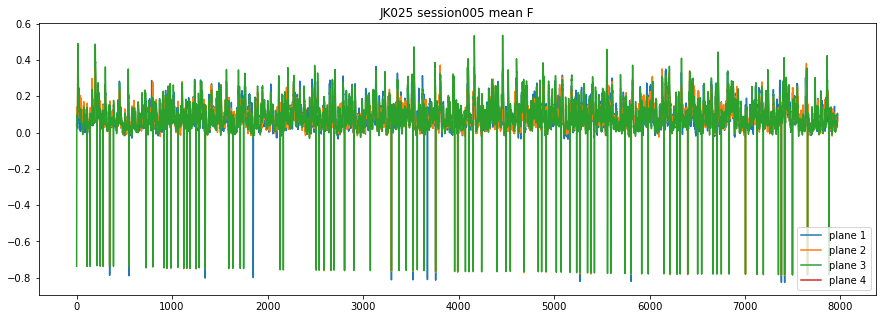

In [100]:
mi = 0
mouse = mice[mi]
if mi < 3:
    base_dir = base_dir_1
else:
    base_dir = base_dir_2

# pi = 5
# plane = planes[pi]
# reg_fn = base_dir / f'{mouse:03}/plane_{plane}/JK{mouse:03}_plane{plane}_session_to_session_registration.npy'
# reg = np.load(reg_fn, allow_pickle=True).item()
# session_nums_to_check = reg['selected_session_num']
# si = 0
# session = session_nums_to_check[si]
session='005'
fig, ax = plt.subplots(1,1,figsize=(15,5))
for plane in range(1,5):
    dff = np.load(base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/dff.npy')
    iscell = np.load(base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/iscell.npy')
    dff = dff[iscell[:,0]==1,:]
    ax.plot(np.mean(dff, axis=0), label=f'plane {plane}')
ax.set_title(f'JK{mouse:03} session{session} mean F')
ax.legend()


In [101]:
np.where(np.isnan(dff))

(array([22, 22, 22, ..., 22, 22, 22], dtype=int64),
 array([   0,    1,    2, ..., 7967, 7968, 7969], dtype=int64))

## Mean dff seems like a good indication.
- Create them all.

In [136]:
for mi in range(len(mice)):
    mouse = mice[mi]
    if mi < 3:
        base_dir = base_dir_1
    else:
        base_dir = base_dir_2
    mouse_dir = base_dir / f'{mouse:03d}'

    for volume in [1,5]:
        volume_dir = mouse_dir / f'plane_{volume}'
        session_nums = []
        for folder in volume_dir.iterdir():
            if folder.is_dir():
                if folder.name[0].isnumeric():
                    session_nums.append(folder.name)
        for session in session_nums:
            fig, ax = plt.subplots(2,1,figsize=(15,10), sharex=True)
            dff_all = []
            for plane in range(volume, volume+4):
                dff_fn = base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/dff.npy'
                if dff_fn.exists():
                    dff = np.load(dff_fn)     
                
                    iscell = np.load(base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/iscell.npy')
                    dff = dff[iscell[:,0]==1,:]
                    ax[0].plot(np.mean(dff, axis=0), alpha=0.5, label=f'plane {plane}')
                    ax[0].legend(loc='upper right')
                    
                    dff_all.append(dff)
            if len(dff_all) == 0:
                continue
            ax[0].set_title(f'JK{mouse:03}_session {session}_volume {volume}')
            ylim = ax[0].get_ylim()
            ax[0].set_ylim([-0.1, ylim[1]*1.1])
            try:
                dff_all = np.concatenate(dff_all, axis=0)
                ax[1].plot(np.mean(dff_all, axis=0), color='k', label='all_mean')
                ax[1].legend(loc='upper right')
                ylim = ax[1].get_ylim()
                ax[1].set_ylim([-0.1, ylim[1]*1.1])
            except:
                ax[1].set_title('averaging failed')
            fig.savefig(mouse_dir / f'JK{mouse:03}_session{session}_volume_{volume}_meanF.png')
            plt.close(fig)


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


# Check for NaN values

In [133]:
mouse = 25
session = '024'
plane = 3
if mouse < 31:
    base_dir = base_dir_1
else:
    base_dir = base_dir_2
dff_saved = np.load(base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/dff.npy')
F = np.load(base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/F.npy')
Fneu = np.load(base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/Fneu.npy')
ops = np.load(base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/ops.npy', allow_pickle=True).item()

assert ops['neucoeff'] == 0.7

dF = F - ops['neucoeff'] *Fneu
win = int(ops['win_baseline'] * ops['fs'])
sig_baseline = ops['sig_baseline']
Flow1 = filters.gaussian_filter(dF,    [0., sig_baseline])
Flow2 = filters.minimum_filter1d(Flow1,    win)
Flow = filters.maximum_filter1d(Flow2,    win)

dff_calc = (dF - Flow) / Flow
dff_calc2 = calculate_suite2p_dff(dF, ops['baseline'], ops['win_baseline'], ops['sig_baseline'], ops['fs'], ops['prctile_baseline'])

In [ ]:
iscell = np.load(base_dir / f'{mouse:03}/plane_{plane}/{session}/plane0/iscell.npy')
cell_inds = np.where(iscell[:,0]==1)[0]

In [115]:
np.where(np.isnan(np.sum(dff_calc[cell_inds,:],axis=1)))

(array([], dtype=int64),)

In [114]:
np.where(np.isnan(np.sum(dff_saved[cell_inds,:],axis=1)))

(array([15], dtype=int64),)

In [110]:
np.where(np.isnan(np.sum(dff_saved[cell_inds,:], axis=1)))

(array([22], dtype=int64),)

In [77]:
np.where(np.isnan(np.sum(Fneu, axis=1)))

(array([], dtype=int64),)

In [79]:

print(win)

366


In [81]:

print(sig_baseline)

10.0


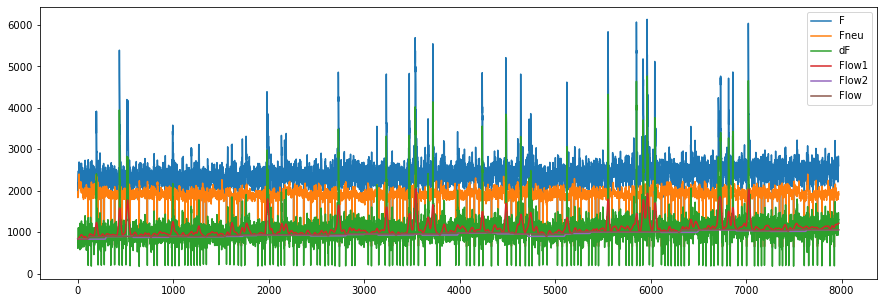

In [97]:
ci = 23
cell_ind = cell_inds[ci]
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(F[cell_ind,:], label='F')
ax.plot(Fneu[cell_ind,:], label='Fneu')
ax.plot(dF[cell_ind,:], label='dF')
ax.plot(Flow1[cell_ind,:], label='Flow1')
ax.plot(Flow2[cell_ind,:], label='Flow2')
ax.plot(Flow[cell_ind,:], label='Flow')
ax.legend()

In [98]:
dff = (dF - Flow) / Flow

In [99]:
np.where(np.isnan(np.sum(dff, axis=1)))

(array([], dtype=int64),)

In [60]:
[d.shape[1] for d in dff_all]

[5006, 5006, 5006, 3877]

In [56]:
session_nums

[1,
 2,
 3,
 4,
 5,
 6,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 22,
 23,
 24,
 25,
 5555001,
 5555002,
 5555003,
 5555004,
 5555012,
 5555013,
 5555014,
 5555103,
 99991,
 99992]